In [1]:
import pandas as pd
import random

from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

random.seed(10)

# Data Setup

Datasets:
* Audit Rates by County from ProPublica 
* Tax Return Data by County from IRS 
* Demographic Data by County from Kaggle


## Audit Rates

* Audit rates (per 1000 returns) gathered by ProPublica
* https://github.com/propublica/auditData

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/propublica/auditData/master/data/cleaned/auditsData_2019.04.03.csv')

In [3]:
df

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk
0,1001,"Autauga County, Alabama",Alabama,95170.0,721.0,7.575917,7.575917
1,1003,"Baldwin County, Alabama",Alabama,362490.0,2833.0,7.815388,7.815388
2,1005,"Barbour County, Alabama",Alabama,39440.0,360.0,9.127789,9.127789
3,1007,"Bibb County, Alabama",Alabama,31840.0,260.0,8.165829,8.165829
4,1009,"Blount County, Alabama",Alabama,87970.0,673.0,7.650335,7.650335
...,...,...,...,...,...,...,...
3136,56037,"Sweetwater County, Wyoming",Wyoming,84960.0,578.0,6.803202,6.803202
3137,56039,"Teton County, Wyoming",Wyoming,57890.0,447.0,7.721541,7.721541
3138,56041,"Uinta County, Wyoming",Wyoming,37540.0,266.0,7.085775,7.085775
3139,56043,"Washakie County, Wyoming",Wyoming,15830.0,110.0,6.948831,6.948831


In [4]:
df[df['audit_rate'] != df['audit_rate_trunk']]
# audit rate trunk - floor of 6 for visualization purposes
# only 63 counties - outliers

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk
67,2013,"Aleutians East Borough, Alaska",Alaska,3960.0,23.0,5.808081,6.0
71,2060,"Bristol Bay Borough, Alaska",Alaska,2140.0,7.0,3.271028,6.0
72,2068,"Denali Borough, Alaska",Alaska,4620.0,26.0,5.627706,6.0
89,2230,"Skagway Municipality, Alaska",Alaska,3050.0,18.0,5.901639,6.0
94,2282,"Yakutat City and Borough, Alaska",Alaska,1160.0,3.0,2.586207,6.0
...,...,...,...,...,...,...,...
2718,48393,"Roberts County, Texas",Texas,1600.0,6.0,3.750000,6.0
2737,48431,"Sterling County, Texas",Texas,2360.0,10.0,4.237288,6.0
2743,48443,"Terrell County, Texas",Texas,1550.0,6.0,3.870968,6.0
2780,49009,"Daggett County, Utah",Utah,1710.0,4.0,2.339181,6.0


In [6]:
# splitting 'fips' code into state and county columns for matching purposes
df['st_code'] = df['fips'].astype('str').str[:-3].astype('int')
df['cty_code'] = df['fips'].astype('str').str[-3:].astype('int')

## Income

In [7]:
# dfi = pd.read_csv('https://raw.githubusercontent.com/Roozbeh-jafari/840.Data-Ethics-US-Taxpayers-Algorithms/main/DataSets/acs2015_county_data.csv?token=APRKZUFFBDGAQVHKEIJZHFTAVKRHK' )
# dfi = pd.read_csv('acs2015_county_data.csv')

dfi = pd.read_csv('../Datasets/acs2015_county_data.csv')

In [8]:
dfi

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,72145,Puerto Rico,Vega Baja,56858,27379,29479,96.4,3.4,0.1,0.0,...,1.2,1.3,0.3,32.0,13660,78.3,17.6,4.1,0.0,15.2
3216,72147,Puerto Rico,Vieques,9130,4585,4545,96.7,2.9,0.0,0.0,...,10.8,0.0,1.4,14.0,2860,44.5,41.6,13.6,0.3,12.2
3217,72149,Puerto Rico,Villalba,24685,12086,12599,99.7,0.0,0.0,0.0,...,3.2,0.0,3.3,26.9,6795,59.2,27.5,13.1,0.2,25.9
3218,72151,Puerto Rico,Yabucoa,36279,17648,18631,99.8,0.2,0.0,0.0,...,2.3,2.3,1.5,29.5,8083,65.1,27.6,7.3,0.0,24.3


## Tax Return

* Tax return characteristics by US county

In [9]:
# dft = pd.read_csv('https://raw.githubusercontent.com/Roozbeh-jafari/840.Data-Ethics-US-Taxpayers-Algorithms/main/DataSets/tax-return-2015.csv?token=APRKZUBW7TZ3AFQU3H6WBZLAVKRJO')
# dft = pd.read_csv('tax-return-2015.csv')

dft = pd.read_csv('../Datasets/tax-return-2015.csv')
dft

,State FIPS code [1],State,County FIPS code [1],County name,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number with paid preparer's signature,Number of exemptions,...,Total tax liability [10] num,Total tax liability [10] amt,Additional Medicare tax num,Additional Medicare tax amt,Net investment income tax num,Net investment income tax amt,Tax due at time of filing [11] num,Tax due at time of filing [11] amt,Overpayments refunded [12] num,Overpayments refunded [12] amt
0,0,US,0,Total [13],148965910,70209250,53923170,21890640,80046180,289089330,...,112137600,1522112987,3475390,7607693,3781620,21033338,28883270,159391261,112176640,350257176
1,1,AL,0,Alabama,2053620,834300,763210,415730,1172420,4166050,...,1458720,14075850,24800,43315,30150,111100,361940,1717754,1607070,4845454
2,1,AL,1,Autauga County,23960,9130,10020,4290,10960,50220,...,17800,135207,120,115,170,387,4310,14233,18910,53521
3,1,AL,3,Baldwin County,93140,38310,39800,12900,46970,183680,...,69840,763095,1450,2138,1840,5128,21340,119349,65910,184209
4,1,AL,5,Barbour County,9590,3560,3020,2860,6590,19710,...,6130,35494,20,32,50,181,1340,4631,7830,24181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3187,56,WY,37,Sweetwater County,20480,8820,8820,2440,10550,43190,...,16550,198517,230,274,310,1109,3390,16251,16440,50305
3188,56,WY,39,Teton County,14310,8120,4780,1120,8080,26350,...,11860,806686,420,2709,1180,61744,4000,52433,8690,201951
3189,56,WY,41,Uinta County,9280,3660,4440,1070,5020,20670,...,7090,71440,70,63,120,566,1590,8646,7330,22735
3190,56,WY,43,Washakie County,3770,1580,1800,360,1990,7610,...,2870,37470,30,31,60,122,750,3035,2740,8604


In [10]:
# adding ratio columns
dft['volunteer_preparer_percentage'] = dft['Number of volunteer prepared returns [2]'] / dft['Number of returns']
dft['paid_preparer_percentage'] = dft['Number with paid preparer\'s signature'] / dft['Number of returns']
dft['wage_income_percentage'] = dft['Salaries and wages in AGI num'] / dft['Number of returns']
dft['dividends_percentage'] = dft['Qualified dividends [5] num'] / dft['Number of returns']
dft['cap_gain_percentage'] =  dft['Net capital gain (less loss) in AGI num'] / dft['Number of returns']
dft['eic_percentage'] =  dft['Earned income credit [7] num'] / dft['Number of returns']

In [11]:
dft[dft['Number of returns'] > 10000].sort_values('dividends_percentage', ascending = False)

# counties w. > 10,000 returns sorted by percentage of returns with divend income (wealthy populations)

,State FIPS code [1],State,County FIPS code [1],County name,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number with paid preparer's signature,Number of exemptions,...,Tax due at time of filing [11] num,Tax due at time of filing [11] amt,Overpayments refunded [12] num,Overpayments refunded [12] amt,volunteer_preparer_percentage,paid_preparer_percentage,wage_income_percentage,dividends_percentage,cap_gain_percentage,eic_percentage
1813,34,NJ,19,Hunterdon County,64620,29980,29410,4120,39990,122900,...,17050,137075,42330,146439,0.018570,0.618849,0.809966,0.397091,0.347261,0.053234
389,12,FL,119,Sumter County,55010,20100,30600,3460,27050,97130,...,14510,69364,34260,132747,0.122160,0.491729,0.447373,0.396110,0.382658,0.098709
212,6,CA,41,Marin County,132580,67110,51990,11250,85400,245630,...,44780,502657,68740,430535,0.020139,0.644139,0.697541,0.394856,0.405189,0.067884
2902,51,VA,75,Goochland County,10870,4360,5410,800,5320,21040,...,2920,28795,6970,27771,0.004600,0.489420,0.793928,0.364305,0.327507,0.099356
1817,34,NJ,27,Morris County,254130,120340,108490,20840,158580,486400,...,61980,546072,172120,685064,0.018416,0.624011,0.823516,0.363869,0.329202,0.066580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,4,AZ,1,Apache County,24580,9840,7090,7400,14170,58140,...,2820,8037,21020,68871,0.048413,0.576485,0.856387,0.031733,0.037022,0.404801
204,6,CA,25,Imperial County,78190,27940,30220,19270,52200,194960,...,12320,56405,63640,190644,0.015219,0.667605,0.886814,0.031206,0.033252,0.419619
1843,35,NM,31,McKinley County,32200,15290,7830,8830,19410,72840,...,2810,9519,28500,89464,0.036025,0.602795,0.866149,0.030124,0.028882,0.468944
2779,48,TX,427,Starr County,24430,8990,8400,6980,16260,58850,...,1970,6699,22160,85737,0.011871,0.665575,0.856734,0.015555,0.015555,0.497339


## Merge

In [12]:
# merging demographic with audit rates
dfmm = df.merge(dfi, how = 'left', left_on='fips', right_on='CensusId').dropna()
dfmm

# dfmm.to_csv('audit-demographics-merged.csv', index = False)
# to save to csv

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk,st_code,cty_code,CensusId,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,"Autauga County, Alabama",Alabama,95170.0,721.0,7.575917,7.575917,1,1,1001.0,...,0.5,1.3,1.8,26.5,23986.0,73.6,20.9,5.5,0.0,7.6
1,1003,"Baldwin County, Alabama",Alabama,362490.0,2833.0,7.815388,7.815388,1,3,1003.0,...,1.0,1.4,3.9,26.4,85953.0,81.5,12.3,5.8,0.4,7.5
2,1005,"Barbour County, Alabama",Alabama,39440.0,360.0,9.127789,9.127789,1,5,1005.0,...,1.8,1.5,1.6,24.1,8597.0,71.8,20.8,7.3,0.1,17.6
3,1007,"Bibb County, Alabama",Alabama,31840.0,260.0,8.165829,8.165829,1,7,1007.0,...,0.6,1.5,0.7,28.8,8294.0,76.8,16.1,6.7,0.4,8.3
4,1009,"Blount County, Alabama",Alabama,87970.0,673.0,7.650335,7.650335,1,9,1009.0,...,0.9,0.4,2.3,34.9,22189.0,82.0,13.5,4.2,0.4,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,56037,"Sweetwater County, Wyoming",Wyoming,84960.0,578.0,6.803202,6.803202,56,37,56037.0,...,2.4,0.9,1.6,21.0,23010.0,78.6,17.7,3.7,0.0,5.4
3137,56039,"Teton County, Wyoming",Wyoming,57890.0,447.0,7.721541,7.721541,56,39,56039.0,...,10.3,4.9,5.5,14.4,14298.0,81.3,11.2,7.5,0.0,2.6
3138,56041,"Uinta County, Wyoming",Wyoming,37540.0,266.0,7.085775,7.085775,56,41,56041.0,...,2.8,1.6,3.0,20.4,10064.0,75.4,19.0,5.6,0.0,4.4
3139,56043,"Washakie County, Wyoming",Wyoming,15830.0,110.0,6.948831,6.948831,56,43,56043.0,...,6.2,2.8,4.5,12.3,3892.0,70.5,21.5,7.6,0.5,6.8


In [28]:
# merging tax return with audit rates
dftm = dft.merge(df, how = 'left',left_on = ['State FIPS code [1]', 'County FIPS code [1]'], right_on= ['st_code', 'cty_code'])
dftm

# dftm.to_csv('tax-return-merged.csv', index= False)   # saving to csv

,State FIPS code [1],State,County FIPS code [1],County name,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number with paid preparer's signature,Number of exemptions,...,eic_percentage,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk,st_code,cty_code
0,0,US,0,Total [13],148965910,70209250,53923170,21890640,80046180,289089330,...,0.187777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,AL,0,Alabama,2053620,834300,763210,415730,1172420,4166050,...,0.253903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,AL,1,Autauga County,23960,9130,10020,4290,10960,50220,...,0.218698,1001.0,"Autauga County, Alabama",Alabama,95170.0,721.0,7.575917,7.575917,1.0,1.0
3,1,AL,3,Baldwin County,93140,38310,39800,12900,46970,183680,...,0.191540,1003.0,"Baldwin County, Alabama",Alabama,362490.0,2833.0,7.815388,7.815388,1.0,3.0
4,1,AL,5,Barbour County,9590,3560,3020,2860,6590,19710,...,0.350365,1005.0,"Barbour County, Alabama",Alabama,39440.0,360.0,9.127789,9.127789,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3187,56,WY,37,Sweetwater County,20480,8820,8820,2440,10550,43190,...,0.125000,56037.0,"Sweetwater County, Wyoming",Wyoming,84960.0,578.0,6.803202,6.803202,56.0,37.0
3188,56,WY,39,Teton County,14310,8120,4780,1120,8080,26350,...,0.079665,56039.0,"Teton County, Wyoming",Wyoming,57890.0,447.0,7.721541,7.721541,56.0,39.0
3189,56,WY,41,Uinta County,9280,3660,4440,1070,5020,20670,...,0.147629,56041.0,"Uinta County, Wyoming",Wyoming,37540.0,266.0,7.085775,7.085775,56.0,41.0
3190,56,WY,43,Washakie County,3770,1580,1800,360,1990,7610,...,0.129973,56043.0,"Washakie County, Wyoming",Wyoming,15830.0,110.0,6.948831,6.948831,56.0,43.0


In [15]:
# merging demographic, tax return, and audit rates
# dataframe with all variables of interest

dfmt = df.merge(dfi, how = 'left', left_on='fips', right_on='CensusId')
dfma = dfmt.merge(dft, how = 'left', left_on =['st_code', 'cty_code'], right_on = ['State FIPS code [1]', 'County FIPS code [1]'] )
dfma

# dfma.to_csv('../Datasets/merged-all.csv', index=False)

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk,st_code,cty_code,CensusId,...,Tax due at time of filing [11] num,Tax due at time of filing [11] amt,Overpayments refunded [12] num,Overpayments refunded [12] amt,volunteer_preparer_percentage,paid_preparer_percentage,wage_income_percentage,dividends_percentage,cap_gain_percentage,eic_percentage
0,1001,"Autauga County, Alabama",Alabama,95170.0,721.0,7.575917,7.575917,1,1,1001.0,...,4310.0,14233.0,18910.0,53521.0,0.021285,0.457429,0.849750,0.114357,0.105175,0.218698
1,1003,"Baldwin County, Alabama",Alabama,362490.0,2833.0,7.815388,7.815388,1,3,1003.0,...,21340.0,119349.0,65910.0,184209.0,0.018252,0.504295,0.775821,0.167490,0.169315,0.191540
2,1005,"Barbour County, Alabama",Alabama,39440.0,360.0,9.127789,9.127789,1,5,1005.0,...,1340.0,4631.0,7830.0,24181.0,0.003128,0.687174,0.819604,0.099062,0.092805,0.350365
3,1007,"Bibb County, Alabama",Alabama,31840.0,260.0,8.165829,8.165829,1,7,1007.0,...,1180.0,6770.0,6560.0,19818.0,0.006281,0.586683,0.866834,0.055276,0.055276,0.285176
4,1009,"Blount County, Alabama",Alabama,87970.0,673.0,7.650335,7.650335,1,9,1009.0,...,3610.0,12250.0,17590.0,49419.0,0.006812,0.638510,0.825613,0.084015,0.075386,0.224342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,56037,"Sweetwater County, Wyoming",Wyoming,84960.0,578.0,6.803202,6.803202,56,37,56037.0,...,3390.0,16251.0,16440.0,50305.0,0.007812,0.515137,0.889160,0.146484,0.130859,0.125000
3137,56039,"Teton County, Wyoming",Wyoming,57890.0,447.0,7.721541,7.721541,56,39,56039.0,...,4000.0,52433.0,8690.0,201951.0,0.026555,0.564640,0.828791,0.320755,0.328442,0.079665
3138,56041,"Uinta County, Wyoming",Wyoming,37540.0,266.0,7.085775,7.085775,56,41,56041.0,...,1590.0,8646.0,7330.0,22735.0,0.006466,0.540948,0.867457,0.133621,0.132543,0.147629
3139,56043,"Washakie County, Wyoming",Wyoming,15830.0,110.0,6.948831,6.948831,56,43,56043.0,...,750.0,3035.0,2740.0,8604.0,0.031830,0.527851,0.816976,0.222812,0.198939,0.129973


# Model

In [17]:
df.audit_rate.mean()
# mean audit rate 

7.730411024322167

In [18]:
df.audit_rate.std()
# standard deviation

0.9803595789832831

## Predicting Audit Rates on Demographics

In [19]:
dfmm['Percentage_Male'] = dfmm['Men'] / (dfmm['Men'] + dfmm['Women'])
dfmm['Percentage_Citizen'] = dfmm['Citizen'] / dfmm['TotalPop'] 
dfmm

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk,st_code,cty_code,CensusId,...,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Percentage_Male,Percentage_Citizen
0,1001,"Autauga County, Alabama",Alabama,95170.0,721.0,7.575917,7.575917,1,1,1001.0,...,1.8,26.5,23986.0,73.6,20.9,5.5,0.0,7.6,0.484327,0.737491
1,1003,"Baldwin County, Alabama",Alabama,362490.0,2833.0,7.815388,7.815388,1,3,1003.0,...,3.9,26.4,85953.0,81.5,12.3,5.8,0.4,7.5,0.488487,0.756941
2,1005,"Barbour County, Alabama",Alabama,39440.0,360.0,9.127789,9.127789,1,5,1005.0,...,1.6,24.1,8597.0,71.8,20.8,7.3,0.1,17.6,0.538282,0.769122
3,1007,"Bibb County, Alabama",Alabama,31840.0,260.0,8.165829,8.165829,1,7,1007.0,...,0.7,28.8,8294.0,76.8,16.1,6.7,0.4,8.3,0.534109,0.773978
4,1009,"Blount County, Alabama",Alabama,87970.0,673.0,7.650335,7.650335,1,9,1009.0,...,2.3,34.9,22189.0,82.0,13.5,4.2,0.4,7.7,0.494056,0.733755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,56037,"Sweetwater County, Wyoming",Wyoming,84960.0,578.0,6.803202,6.803202,56,37,56037.0,...,1.6,21.0,23010.0,78.6,17.7,3.7,0.0,5.4,0.521732,0.691615
3137,56039,"Teton County, Wyoming",Wyoming,57890.0,447.0,7.721541,7.721541,56,39,56039.0,...,5.5,14.4,14298.0,81.3,11.2,7.5,0.0,2.6,0.517099,0.733764
3138,56041,"Uinta County, Wyoming",Wyoming,37540.0,266.0,7.085775,7.085775,56,41,56041.0,...,3.0,20.4,10064.0,75.4,19.0,5.6,0.0,4.4,0.508170,0.685953
3139,56043,"Washakie County, Wyoming",Wyoming,15830.0,110.0,6.948831,6.948831,56,43,56043.0,...,4.5,12.3,3892.0,70.5,21.5,7.6,0.5,6.8,0.493333,0.725000


In [20]:
# Predicting Solely on Demographic Variables

Xd = dfmm[[ 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific',  'Income']]

Xd

,Hispanic,White,Black,Native,Asian,Pacific,Income
0,2.6,75.8,18.5,0.4,1.0,0.0,51281.0
1,4.5,83.1,9.5,0.6,0.7,0.0,50254.0
2,4.6,46.2,46.7,0.2,0.4,0.0,32964.0
3,2.2,74.5,21.4,0.4,0.1,0.0,38678.0
4,8.6,87.9,1.5,0.3,0.1,0.0,45813.0
...,...,...,...,...,...,...,...
3136,15.8,79.9,0.8,0.2,0.9,0.5,69022.0
3137,15.1,81.2,0.2,0.4,1.9,0.0,75325.0
3138,8.9,87.8,0.2,0.4,0.1,0.0,56569.0
3139,14.0,82.4,0.7,0.3,0.2,0.0,47652.0


In [21]:
yd = dfmm['audit_rate']
yd

0       7.575917
1       7.815388
2       9.127789
3       8.165829
4       7.650335
          ...   
3136    6.803202
3137    7.721541
3138    7.085775
3139    6.948831
3140    7.244212
Name: audit_rate, Length: 3138, dtype: float64

In [22]:
lmd = linear_model.LinearRegression()
lmd.fit(Xd, yd)

LinearRegression()

In [23]:
cframe = pd.DataFrame({'var': Xd.columns, 'coef': lmd.coef_})
cframe

,var,coef
0,Hispanic,-0.006848
1,White,-0.021091
2,Black,0.007953
3,Native,-0.004530
4,Asian,0.003075
5,Pacific,-0.095208
6,Income,-0.000032


In [24]:
lmd.coef_

array([-6.84770888e-03, -2.10911589e-02,  7.95333875e-03, -4.53002936e-03,
        3.07467431e-03, -9.52078645e-02, -3.21104070e-05])

In [25]:
scoresd = cross_val_score(lmd, Xd, yd, scoring = 'neg_root_mean_squared_error')
scoresd

array([-0.77926079, -0.467718  , -0.87574846, -0.62537795, -0.8608938 ])

In [26]:
scoresd.mean()

-0.7217997986192133

## Predicting Audit Rates on Tax Return Characteristics

### LR - all tax

In [29]:
dftm.dropna(inplace= True)

X = dftm.iloc[:, 4:131]
y = dftm['audit_rate']

In [30]:
lm2 = linear_model.LinearRegression()
lm2.fit(X,y)

LinearRegression()

In [31]:
scores2 = cross_val_score(lm2, X,y, cv = 10,  scoring= 'neg_root_mean_squared_error')
scores2, scores2.mean()
# Linear model is poor predictor with this dataset
# Try non-linear model (decision tree next)

(array([-2.05961464, -1.61901112, -0.55407973, -0.78217482, -0.88361248,
        -1.70482932, -1.01154222, -0.91414916, -1.72274361, -0.67256148]),
 -1.1924318588659826)

### Decision Tree - all tax

In [32]:
dt = DecisionTreeRegressor()
dt.fit(X,y)

DecisionTreeRegressor()

In [33]:
scores3 = cross_val_score(dt, X,y, cv = 10,  scoring= 'neg_root_mean_squared_error')
scores3, scores3.mean()

(array([-0.66197614, -0.60174449, -0.48407762, -0.51839446, -0.54508634,
        -0.90692529, -0.50611713, -0.57634963, -0.97577835, -0.46890528]),
 -0.6245354719792514)

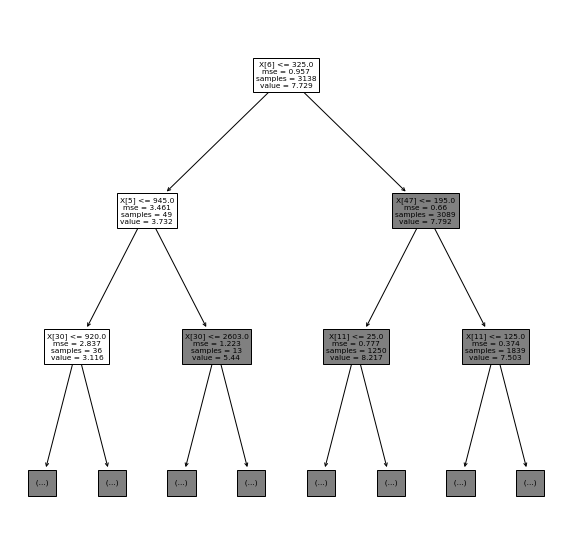

In [34]:


plt.figure(figsize = [10,10])
tree.plot_tree(dt, max_depth=2)
plt.show()

### Random Forest - all tax

In [35]:
rf = RandomForestRegressor()
rf.fit(X,y)

RandomForestRegressor()

In [36]:
scores4 = cross_val_score(dt, X,y, cv = 10,  scoring= 'neg_root_mean_squared_error')
scores4, scores4.mean()
# RF regressor doesn't improve over simple decision tree

(array([-0.67830121, -0.58286528, -0.48924732, -0.52877824, -0.56044567,
        -1.01895388, -0.50245715, -0.57206838, -1.02960689, -0.45851391]),
 -0.642123791432123)

### Selected ratios

In [37]:
dftm.dropna(inplace= True)
dftm.shape

(3138, 146)

In [38]:
X2 = dftm.iloc[: , 131:136]
X2

,volunteer_preparer_percentage,paid_preparer_percentage,wage_income_percentage,dividends_percentage,cap_gain_percentage
2,0.021285,0.457429,0.849750,0.114357,0.105175
3,0.018252,0.504295,0.775821,0.167490,0.169315
4,0.003128,0.687174,0.819604,0.099062,0.092805
5,0.006281,0.586683,0.866834,0.055276,0.055276
6,0.006812,0.638510,0.825613,0.084015,0.075386
...,...,...,...,...,...
3187,0.007812,0.515137,0.889160,0.146484,0.130859
3188,0.026555,0.564640,0.828791,0.320755,0.328442
3189,0.006466,0.540948,0.867457,0.133621,0.132543
3190,0.031830,0.527851,0.816976,0.222812,0.198939


In [39]:
lm = linear_model.LinearRegression()

In [40]:
lm.fit(X2, y)

LinearRegression()

In [41]:
scores2 = cross_val_score(lm, X2, y, cv = 5, scoring= 'neg_root_mean_squared_error')
scores2

array([-0.93700235, -0.58589093, -1.01541658, -0.68158107, -1.07974774])

In [42]:
scores2.mean()
# using just selected ratios is predictive, but significantly less than model that uses all characteristics

-0.8599277323972541

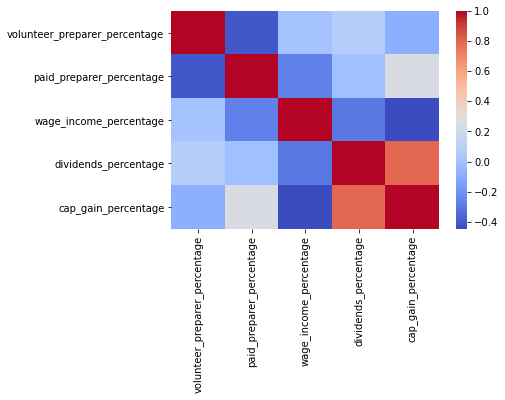

In [43]:
# Heatmap to show relationships between predictors and audit rates

sns.heatmap(X2.corr(), cmap = 'coolwarm')
plt.show()

# EDA 

## Unemployment

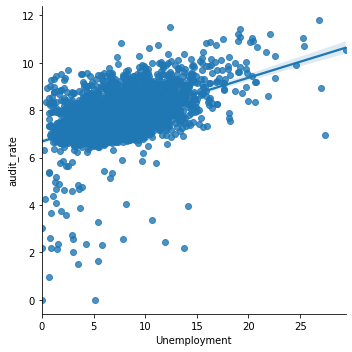

In [44]:
sns.lmplot(x ='Unemployment', y = 'audit_rate', data = dfmm)